In [56]:
import sys
sys.path.insert(0, "../..")

import optax
import jax
import jax.numpy as jnp
from functools import reduce
import jax.numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
import netket
import jax.numpy as jnp
import netket.jax
from jax import jit
import math
from functools import partial
import module.misc.atomic_orbitals as atom

## Evaluate the hydrogen wavefunctions:

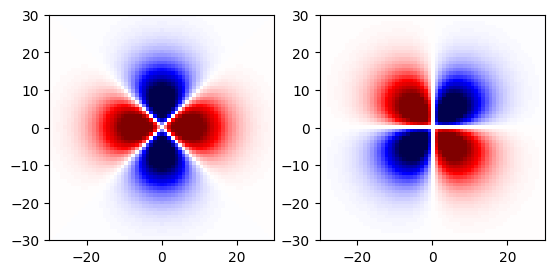

In [32]:
g = 30
N = 63
xs = jnp.linspace(-g,g, num = N)
ys = jnp.linspace(-g,g, num = N)
zs = jnp.linspace(0,0, num = 1)
xx,yy,zz = jnp.meshgrid(xs,ys,zs)
pos = jnp.stack((xx.flatten(), yy.flatten(), zz.flatten()), axis = 1)

psi = atom.evaluate(3,2,2,1,pos).reshape((N,N,1))


f, ax = plt.subplots(1, 2)
r = 0.01
ax[0].imshow(jnp.real(psi[:,:,0]), cmap = "seismic", vmin = -r, vmax = r, extent = [-g,g,-g,g])
ax[1].imshow(jnp.imag(psi[:,:,0]), cmap = "seismic", vmin = -r, vmax = r, extent = [-g,g,-g,g])

In [64]:
f = lambda pos: jnp.real(atom.evaluate(1,0,0,1,jnp.array([pos])).squeeze())

Array(2.95222712e-16, dtype=float64)

In [68]:
prim, vjpfun = jax.vjp(f, pos[1])
vjpfun(1.)

(Array([2.90314890e-19, 2.99992053e-19, 0.00000000e+00], dtype=float64),)

In [29]:
def spherical_harmonic(l, m, phi, theta):
    theta = jnp.array(theta)

    if not isinstance(phi, jax.numpy.ndarray):
        phi = jnp.ones_like(theta) * phi
    
    l = jnp.ones_like(phi, dtype="int")*l
    m = jnp.ones_like(phi, dtype="int")*m

    y = jax.scipy.special.sph_harm(m, l, phi, theta)
    return y

In [26]:
spherical_harmonic(1,-1,jnp.pi/2,jnp.array([jnp.pi/2]))

Array([2.11554152e-17-0.34549415j], dtype=complex128)

In [27]:
jnp.sqrt(3/8/jnp.pi)

Array(0.34549415, dtype=float64, weak_type=True)

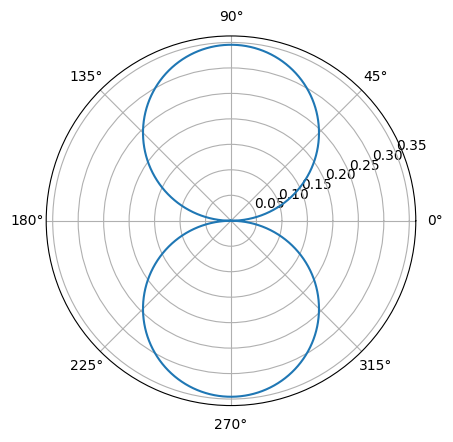

In [3]:
phi = 0
theta = jnp.linspace(0, 2*jnp.pi, num = 1000)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.plot(theta, jnp.real(spherical_harmonic(1, -1, phi, theta)))
ax.plot(theta, jnp.imag(spherical_harmonic(1, -1, phi, theta)))

In [45]:
def assoc_laguerre(n, k, x):
    if n < 0:
        raise Exception("n has to be non-negativ in asoociated Laguerre polynomials")

    if n == 0:
        return 1
    
    if n == 1:
        return -x + k + 1
    
    return 1/n*((2*n - 2 + 1 + k -x)*assoc_laguerre(n-1, k, x) - (n -1 + k)*assoc_laguerre(n-2,k,x))

In [101]:
def ass_lag(n, k, x):
    if n < 0:
        raise Exception("n has to be non-negativ in asoociated Laguerre polynomials")

    if n == 0:
        return 1

    carry = jnp.array([-x+k+1,1])

    for i in range(1, n):
        A = jnp.array([[(2*i+1+k-x)/(i+1), 1],[-(i+k)/(i+1),0]]).T
        carry = A @ carry

    return carry[0]

ass_lag = jax.vmap(ass_lag, in_axes=[None, None, 0])

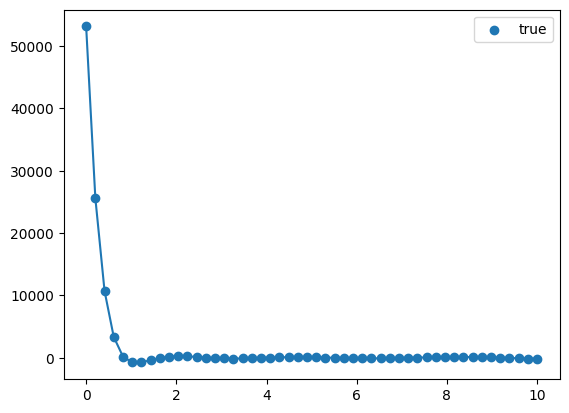

In [128]:
xs = jnp.linspace(0,10)
ys = ass_lag(20,5,xs)
ys2 = assoc_laguerre(20,5,xs)
plt.plot(xs,ys)
plt.scatter(xs,ys2, label = "true")
plt.legend()

In [129]:
def radial_part(n, l, Z, r):
    a = (2*Z*r/n)**l * jnp.exp(-Z*r/n) * ass_lag(n-l-1, 2*l+1, 2*Z*r/n) * math.factorial(n + l)
    A = (2*Z/n)**3*math.factorial(n-l-1)/2/n/math.factorial(n+l)**3
    return a * jnp.sqrt(A)

In [198]:
class HydrogenicOrbital:
    def __init__(self, n, l, m, Z):

        assert n > 0, "n has to be positive"
        assert l >= 0, "l has to be non negative"
        assert l < n, "l has to be less than n"
        assert jnp.abs(m) <= l, "abs(m) has to be less or equal to l"

        self.n = n
        self.l = l
        self.m = m
        self.Z = Z

        self.assoc_laguerre = jax.vmap(self.ass_lag, in_axes=[None,None,0])

    def spherical_harmonic(self, l, m, phi, theta):
        """
        Calculates the spherical harmonics Y_l^{m} at positions phi and theta.
        """
        theta = jnp.array(theta)

        if not isinstance(phi, jax.numpy.ndarray):
            phi = jnp.ones_like(theta) * phi
        
        l = jnp.ones_like(phi, dtype="int")*l
        m = jnp.ones_like(phi, dtype="int")*m

        y = jax.scipy.special.sph_harm(m, l, phi, theta)
        return y


    @partial(jax.jit, static_argnames=['self','n','k'])    
    def ass_lag(self, n, k, x):
        """
        Calculazed the n,k-th associated Laguerre polynomial at position x.
        """
        if n < 0:
            raise Exception("n has to be non-negative in asoociated Laguerre polynomials")

        if n == 0:
            return 1

        carry = jnp.array([-x+k+1,1])

        for i in range(1, n):
            A = jnp.array([[(2*i+1+k-x)/(i+1), 1],[-(i+k)/(i+1),0]]).T
            carry = A @ carry

        return carry[0]

    @partial(jax.jit, static_argnames=['self'])    
    def radial_part(self, r):
        """
        Calculates the properly normalised radial part of the wavefunction.
        """
        a = (2*self.Z*r/self.n)**self.l * jnp.exp(-self.Z*r/self.n) * self.assoc_laguerre(self.n-self.l-1, 2*self.l+1, 2*self.Z*r/self.n) * math.factorial(self.n + self.l)
        A = (2*self.Z/self.n)**3*math.factorial(self.n-self.l-1)/2/self.n/math.factorial(self.n+self.l)**3
        return a * jnp.sqrt(A)


    def evaluate(self, position):
        x = position[:,0]
        y = position[:,1]
        z = position[:,2]

        r = jnp.sqrt(x ** 2 + y ** 2 + z ** 2)
        theta = jnp.arccos(z / r)
        phi = jnp.arctan2(y, x)

        radial = self.radial_part(r)
        angular = self.spherical_harmonic(self.l, self.m, phi, theta)

        return radial * angular
    
    def calc_logpsi(self, position):
        return jnp.log(self.evaluate(position))

In [199]:
g = 10
N = 500
xs = jnp.linspace(-g,g, num = N)
ys = jnp.linspace(-g,g, num = N)
zs = jnp.linspace(0,0, num = 1)
xx,yy,zz = jnp.meshgrid(xs,ys,zs)
pos = jnp.stack((xx.flatten(), yy.flatten(), zz.flatten()), axis = 1)

In [200]:
orb = HydrogenicOrbital(2,1,1,1)
psi = orb.evaluate(pos).reshape((N,N,1))

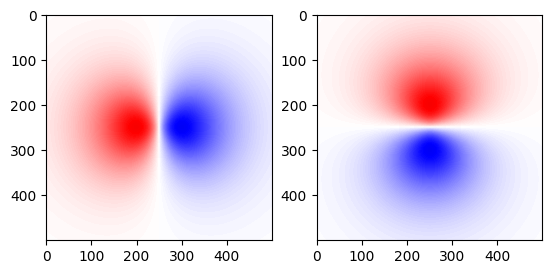

In [201]:
f, ax = plt.subplots(1, 2)
r = 0.1
ax[0].imshow(jnp.real(psi[:,:,0]), cmap = "seismic", vmin = -r, vmax = r)
ax[1].imshow(jnp.imag(psi[:,:,0]), cmap = "seismic", vmin = -r, vmax = r)

In [203]:
log = orb.calc_logpsi(pos).reshape((N,N,1))

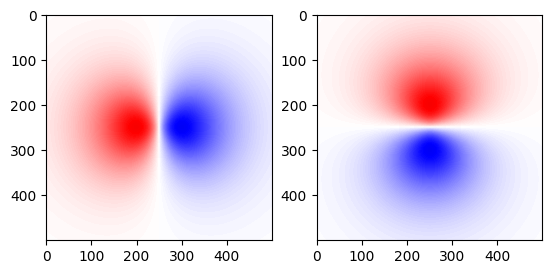

In [205]:
f, ax = plt.subplots(1, 2)
r = 0.1
ax[0].imshow(jnp.real(jnp.exp(log[:,:,0])), cmap = "seismic", vmin = -r, vmax = r)
ax[1].imshow(jnp.imag(jnp.exp(log[:,:,0])), cmap = "seismic", vmin = -r, vmax = r)

In [179]:
# yeah i think it works :)